# Conditional Variational Autoencoder(CVAE) for Anomaly Detection
Donglin Liu <br>
Jupyter-course project

# Introduction

The project will first give a general introduction to variational autoencoder(VAE), then the conditional variational autoencoder(CVAE) will be discussed. This proposed conditional variational autonencoder improves latent space separation by conditioning on information within the data. The method fits a unique prior distribution to each class in the dataset, effectively expanding the classic prior distribution for variational autoenconders to include a Gaussian mixture model. Such probability regions in latent space can help us to evaluate their degree of anomaly.

The experiments is implemented by Tensorflow 2.X using Keras API on MINST dataset. And all the results has saved in text files, no need to train the model again. 
The idea of this work is mainly based on the paper [[1]](#refer-anchor-1),[[4]](#refer-anchor-4). The code is inspired by project [[2]](#refer-anchor-2),[[3]](#refer-anchor-3).

# VAE

For many machine learning algorithm, the size of dataset always play an important role. But data collection can be expensive, time consuming and difficult. The ideal condition is we know the distribution of the dataset $p_\theta(x)$, so that we can easily to generate new data by the distribution. VAE is try to solve this problem.

Usually, data from real world have unknown distribution in high dimensional space. So we can construct a latent variable $z$ to generate target dataset $X$ which is the basic goal of VAE. To be more precise, $z$ is generated from some prior distribution $p_\theta(z)$ which hypothetical by some common distribution (such as normal distribution or uniform distribution). Then we want to find a transformation $g$ from likelihood $p_\theta(x|z)$ such that $X=g(z)$. The transformation $g$ maps the original probability distribution of $z$ to the probability distribution of the target dataset $X$.

We know the integral of the marginal likelihood $p_\theta(x) = \int p_\theta(z)p_\theta(x|z)dz$ is intractable. The posterior density $p_\theta(z|x) = \frac{p_\theta(x|z)p_\theta(z)}{p_\theta(x)}$ is also intractable. But $p_\theta(z|x)$ can be considered using $q_\phi(z|x)$ to approximate. We will refer to $q_\phi(z|x)$ as a probabilistic encoder and $p_\theta(x|z)$ as a probabilistic decoder.

For the purpose of solving $p_\theta(x)$, we now just need a method for learning the encoder parameters $\phi$ and decoder parameters $\theta$ if we just consider these two models are two neural networks.

\begin{eqnarray*}
logp_\theta(x) &=& E_{z\sim q_{\phi(z|x)}}[logp_{\theta}(x)] \qquad\text{By p(x) not depend on z}\\
               &=& E_{z}[log\frac{p_{\theta}(x|z)p(z)}{p_{\theta}(z|x)}] \qquad\text{By bayer's rule}\\
               &=& E_z[log\frac{p_{\theta}(x|z)p_{\theta}(z)}{p_{\theta}(z|x)}\frac{q_{\phi}(z|x)}{q_{\phi}(z|x)}]\\
               &=& E_z[logp_\theta(x|z)]-E_z[log\frac{q_\phi(z|x)}{p_\theta(z)}]+E_z[log\frac{q_\phi(z|x)}{p_\theta(z|x)}]\\
               &=& \underbrace{E_z[logp_\theta(x|z)]-D_{KL}(q_\phi(z|x)\|p_\theta(z))}_{\text{tractable lower bound $\mathcal{L}(\theta,\phi;x)$}}+\underbrace{D_{KL}(q_\phi(z|x)\|p_\theta(z|x))}_{\text{intractable, but $D_{KL}\ge 0$}}
\end{eqnarray*}

The lower bound of $logx_\theta(x)$ is shown above to be,
$$\mathcal{L}(\theta,\phi;x)=E_{z\sim q_{\phi}(z|x)}[logp_\theta(x|z)]-D_{KL}(q_\phi(z|x)\|p_\theta(z))$$
The task is to maximize the $\mathcal{L}$ with respect to the parameters $\theta$ and $\phi$,
$$\phi^{\ast},\theta^{\ast}=\mathop{\arg\max}_{\phi,\theta}\mathcal{L}(\theta,\phi;x)$$


Let the prior over the latent variables be the centered isotropic multivariate Gaussian $p_\theta(z) = \mathcal{N}(z;0,I)$.
We also assume the approximate posterior $q_\phi(z|x)$ in Gaussian form with an approximately diagonal covariance
$$logq_\phi(z|x^{(i)})=log\mathcal{N}(z;\mu^{(i)},\sigma^{2(i)}I)$$
The $D_{KL}$ term in $\mathcal{L}$ can be derive as follows:
\begin{eqnarray*}
D_{KL}(q_\phi(z|x)\|p_\theta(z)) &=& E_{z\sim q_\phi(z|x)}[logq_\phi(z|x)]-E_{z\sim q_\phi(z|x)}[logp_\theta(z)]\\
   &=& E_z[log\frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}}exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))]-E_z[log\frac{1}{(2\pi)^{1/2}|\Sigma|^{1/2}}exp(-\frac{1}{2}\|x\|^2)]\\
   &=& -\frac{d}{2}log(2\pi)-\frac{1}{2}log\mathop{\Pi}_{i=1}^{d}\sigma_{i}^{2}-\underbrace{E_z[exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))]}_{=-\frac{d}{2}}+-\frac{d}{2}log(2\pi)+\frac{1}{2}\mathop{\sum}_{i=1}^{d}(\mu_{i}^2+\sigma_{i}^2)\\
   &=& -\frac{1}{2}\mathop{\sum}_{i=1}^{d}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)
\end{eqnarray*}
So $\mathcal{L}(\theta,\phi;x)=\frac{1}{2}\mathop{\sum}_{i=1}^{d}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)+\frac{1}{L}\mathop{\sum}_{l=1}^{L}logp_\theta(x|z^{l})$,
where $z^l=\mu+\sigma\odot\epsilon^l$ and $\epsilon^l\sim \mathcal{N}(0,I)$.
Here $\epsilon$ is for sampling $z^l$ called reparameterization trick.

### Build the VAE model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# %conda env export > requirements.yml

2022-06-13 12:15:25.627296: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In this example code, for encoder, we assume $q_\phi(z|x^{(i)})=\mathcal{N}(z;\mu^{(i)},\sigma^{2(i)}I)$ and specify the mean $\mu_\phi(x)$ and log variance $log\sigma_\phi^2(x)$ of this distribution as the output of an inference network.

In [2]:
original_dim, intermediate_dim, latent_dim = 784, 256, 2

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

encoder = Model(x, z_mu)

2022-06-13 12:15:27.079091: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-13 12:15:27.103031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 12:15:27.103216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.425GHz coreCount: 30 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 312.97GiB/s
2022-06-13 12:15:27.103293: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-13 12:15:27.123174: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-13 12:15:27.123301: I tensorflow/stream_e

Now we sampling in probability space of $z$ by reparameterization trick.

In [3]:
def sampling(args):
    z_mu, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim)) #default mean=0, stddev=1
    return z_mu + K.exp(.5*z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var]) # sampling

For $p_\theta(x|z)$ the decoder part, it is straightforward to implement this in Keras with the Sequential model API:

In [4]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_recon = decoder(z)
vae = Model(inputs=x, outputs=x_recon)

The loss function is just $-\mathcal{L}(\theta,\phi;x)$ as we discussed above

In [5]:
#keras.losses.binary_crossentropy gives the mean over the last axis. we require the sum
xent_loss = K.sum(K.binary_crossentropy(x, x_recon), axis=-1) 
kl_loss = K.mean(- .5 * K.sum(1 + z_log_var - K.square(z_mu) - K.exp(z_log_var), axis=-1))
vae_loss = xent_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')#, loss=nll)

The $\mu$ for test dataset in latent space has been saved in text file. If you want to repeat it, you can run the following code.

In [6]:
# train the VAE on MNIST digits
(x_train, Y_train), (x_test, Y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=50,
        batch_size=64,
        validation_data=(x_test, x_test))


11493376/11490434 [==============================] - 5s 0us/step


2022-06-13 12:15:43.528931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-13 12:15:43.547787: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3194070000 Hz


Epoch 1/50
938/938 [==============================] - 5s 5ms/step - loss: 185.9391 - val_loss: 170.9673
Epoch 2/50
938/938 [==============================] - 5s 5ms/step - loss: 168.7590 - val_loss: 165.8243
Epoch 3/50
938/938 [==============================] - 4s 5ms/step - loss: 164.4004 - val_loss: 162.6502
Epoch 4/50
938/938 [==============================] - 5s 5ms/step - loss: 161.8446 - val_loss: 160.6538
Epoch 5/50
938/938 [==============================] - 5s 5ms/step - loss: 160.1456 - val_loss: 159.6623
Epoch 6/50
938/938 [==============================] - 5s 5ms/step - loss: 158.8512 - val_loss: 158.3822
Epoch 7/50
938/938 [==============================] - 5s 5ms/step - loss: 157.7969 - val_loss: 157.4597
Epoch 8/50
938/938 [==============================] - 5s 5ms/step - loss: 156.9130 - val_loss: 156.7713
Epoch 9/50
938/938 [==============================] - 5s 5ms/step - loss: 156.1543 - val_loss: 156.1681
Epoch 10/50
938/938 [==============================] - 5s 5ms/st

Load $\mu$ and plot it based on different classes

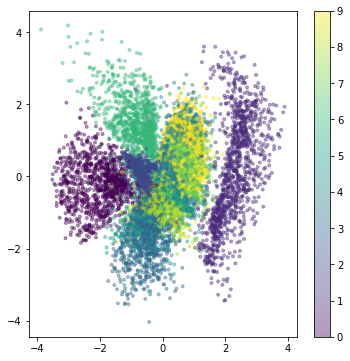

In [9]:
vae_z = encoder.predict(x_test, batch_size=100)
np.savetxt('vae_z.txt',np.c_[vae_z,Y_test],fmt='%.3e',delimiter=",",header='x,y,label',comments='')
vae_z = pd.read_csv('vae_z.txt')
plt.figure(figsize=(6, 6))
plt.scatter(vae_z['x'], vae_z['y'], c=vae_z['label'], alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# CVAE

VAEs are designed to estimate the unknown probability distribution $p_\theta(x)$ for the given dataset $X$ using a Gaussian in latent space. Instead, CVAE is try to estimate $p_\theta(x|y)$, where $y$ is the label from dataset $X$.

Similarly,
\begin{eqnarray*}
logp_\theta(x|y) &=& E_{z\sim q_{\phi(z|x,y)}}[logp_{\theta}(x|y)] \qquad\text{By p(x) not depend on z}\\
                 &=& E_{z}[log\frac{p_{\theta}(x,y,z)}{p_{\theta}(z|x,y)p_\theta(y)}] \qquad\text{By bayer's rule}\\
                 &=& E_z[log\frac{p_{\theta}(x,y,z)}{p_\theta(y)}\frac{1}{p_{\theta}(z|x,y)}\frac{q_{\phi}(z|x,y)}{q_{\phi}(z|x,y)}]\\
                 &=& \underbrace{E_z[log\frac{p_\theta(x,z|y)}{q_\phi(z|x,y)}]}_{\mathcal{L(\theta,\phi;x})}+D_{KL}(q_\phi(z|x,y)\|p_\theta(z|x,y))
\end{eqnarray*}
$\mathcal{L(\theta,\phi;x})$ is lower bound of $logp_\theta(x|y)$.
\begin{eqnarray*}
\mathcal{L(\theta,\phi;x}) &=& E_{z\sim q(z|x,y)}[log\frac{p_\theta(x|z,y)p_\theta(z|y)}{q_\phi(z|x,y)}]\\
    &=& E_z[log\frac{p_\theta(z|y)}{q_\phi(z|x,y)}]+E_z[logp_\theta(x|z,y)]\\
    &=& -D_{KL}(q_\phi(z|x,y)\|p_\theta(z|y))+E_z[logp_\theta(x|z,y)] 
\end{eqnarray*}


Different from VAE, we use a Gaussion Mixture model for better seperation in latent space, let  $p_\theta(z|y)=\mathcal{N}(\mu_y,I)$, where $\mu_y$ is different by classes. Since $p(y)$ is known and $p(z|y)$ is given, we have $p(z|x,y)=p(z|x)$

\begin{eqnarray*}
\mathcal{L(\theta,\phi;x}) &=& -D_{KL}(q_\phi(z|x)\|p_\theta(z|y))+E_z[logp_\theta(x|z,y)] \\
    &=& -E_{z\sim q_\phi(z|x)}[log\frac{q_\phi(z|x)}{p_\theta(z|y)}]+\frac{1}{L}\mathop{\sum}_{l=1}^{L}(logp_\theta(x|z^{(l)},y))\\
    &=& -E_z[-\frac{1}{2}\mathop{\sum}_{i=1}^{d}(log\sigma^2_i(x)-\|z-\mu_y\|^2)]+\frac{1}{L}\mathop{\sum}_{l=1}^{L}(logp_\theta(x|z^{(l)},y))\\
    &\sim& \frac{1}{2}\mathop{\sum}_{i=1}^{d}(log\sigma^2_i(x)-\|z-\mu_y\|^2)+\frac{1}{L}\mathop{\sum}_{l=1}^{L}(logp_\theta(x|z^{(l)},y))\\
\end{eqnarray*}
where $z^{(l)}$ is resampled as in VAE.

### Build the CVAE model
By deriving the loss function as above, we can see that the main difference is we use GMM(Gaussion Mixture Model). So it is same for encoder and decoder part as in VAE.

In [10]:
original_dim, intermediate_dim, latent_dim = 784, 256, 2
num_classes = 10

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

label = Input(shape=(num_classes,))
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var]) # sampling

x_recon = decoder(z)

In order to train $\mu_y$, we build a Gaussian layer with weight matrix shape 10*2 to represent $\mu_y$ for 10 different classes in MINST. 

In [13]:
class Gaussian(Layer):
    """这是个简单的层，定义q(z|y)中的均值参数，每个类别配一个均值。
    然后输出“z - 均值”，为后面计算loss准备。
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)
    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                                    shape=(self.num_classes, latent_dim),
                                    initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_classes': self.num_classes
        })
        return config
    
gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)

# 建立模型
cvae = Model([x,label], [x_recon, z_prior_mean])
encoder = Model([x,label], z_mu)

Loss function is 
\begin{eqnarray}
-\mathcal{L} &=& D_{KL}(q_\phi(z|x)\|p_\theta(z|y))-E_z[logp_\theta(x|z,y)] \\
&\sim& -\frac{1}{2}\mathop{\sum}_{i=1}^{d}(log\sigma^2_i(x)-\|z-\mu_y\|^2)-\frac{1}{L}\mathop{\sum}_{l=1}^{L}(logp_\theta(x|z^{(l)},y))
\end{eqnarray}
which derived above. By intuition, $D_{KL}(q_\phi(z|x)\|p_\theta(z|y))$ is for cluster. Making $p(z|y)$ in its own Gaussian model by different classes. $logp_\theta(x|z,y)$ is for reducing reconstruction error, to save more information in $z$. So in order to have a better seperation, we add weight $\lambda=0.3$ to $E_z[logp_\theta(x|z,y)]$.

In [14]:
# 下面一大通都是为了定义loss
z_mu = K.expand_dims(z_mu, 1)
z_log_var = K.expand_dims(z_log_var, 1)

lamb = 0.3 # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(label, 1), kl_loss), 0)
# cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
cvae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss)# + K.sum(cat_loss)

cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')

(x_train, Y_train), (x_test, Y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim).astype(np.float32) / 255.
x_test = x_test.reshape(-1, original_dim).astype(np.float32) / 255.

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

The $\mu$ for test dataset in latent space has been saved in text file. If you want to repeat it, you can run the following code.

In [15]:
cvae.fit([x_train,y_train],
        shuffle=True,
        epochs=50,
        batch_size=64,
        validation_data=[x_test,y_test])

Epoch 1/50
938/938 [==============================] - 5s 4ms/step - loss: 73.5099 - val_loss: 71.7939
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 71.5949 - val_loss: 71.6667
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 71.6010 - val_loss: 71.8025
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 71.6494 - val_loss: 71.6230
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 72.4374 - val_loss: 71.9025
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 71.7641 - val_loss: 70.9517
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 72.0763 - val_loss: 72.4002
Epoch 8/50
938/938 [==============================] - 4s 4ms/step - loss: 71.9339 - val_loss: 70.7948
Epoch 9/50
938/938 [==============================] - 4s 4ms/step - loss: 72.0964 - val_loss: 71.1164
Epoch 10/50
938/938 [==============================] - 4s 4ms/step - loss: 71.5118

The following figures show that latent space of CVAE have better seperation than VAE. This can help us do anomaly detection.

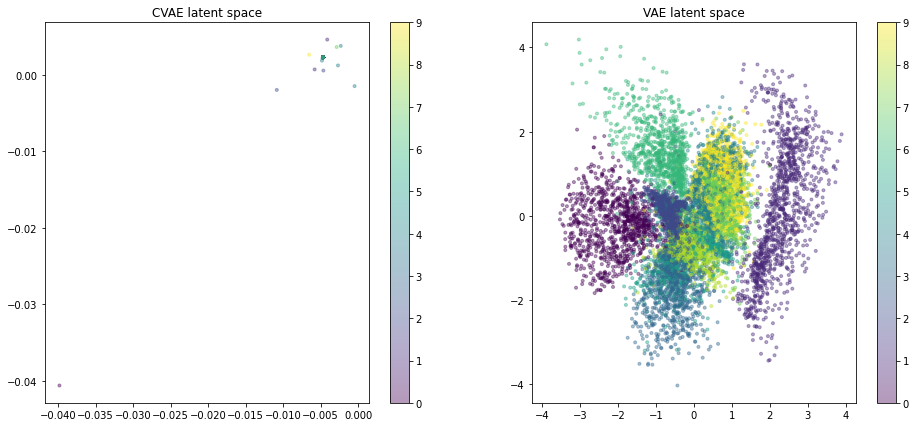

In [25]:
cvae_z = encoder.predict([x_test,y_test], batch_size=100)
np.savetxt('cvae_z.txt',np.c_[cvae_z[:,0,:],Y_test],fmt='%.3e',delimiter=",",header='x,y,label',comments='')
vae_z = pd.read_csv('vae_z.txt')
cvae_z = pd.read_csv('cvae_z.txt')

fig, ax = plt.subplots(1,2,figsize=(16,7))
ax_0 = ax[0].scatter(cvae_z['x'], cvae_z['y'], c=cvae_z['label'], alpha=.4, s=3**2, cmap='viridis')
ax[0].set_title("CVAE latent space")
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].scatter(vae_z['x'], vae_z['y'], c=vae_z['label'], alpha=.4, s=3**2, cmap='viridis')
ax[1].set_title("VAE latent space")
fig.colorbar(ax_0, ax=ax[1])
# fig.show()

# Anomaly detection

The results of running anomaly detection using the LOF algorithm on CVAE latent space over each class are shown as below.

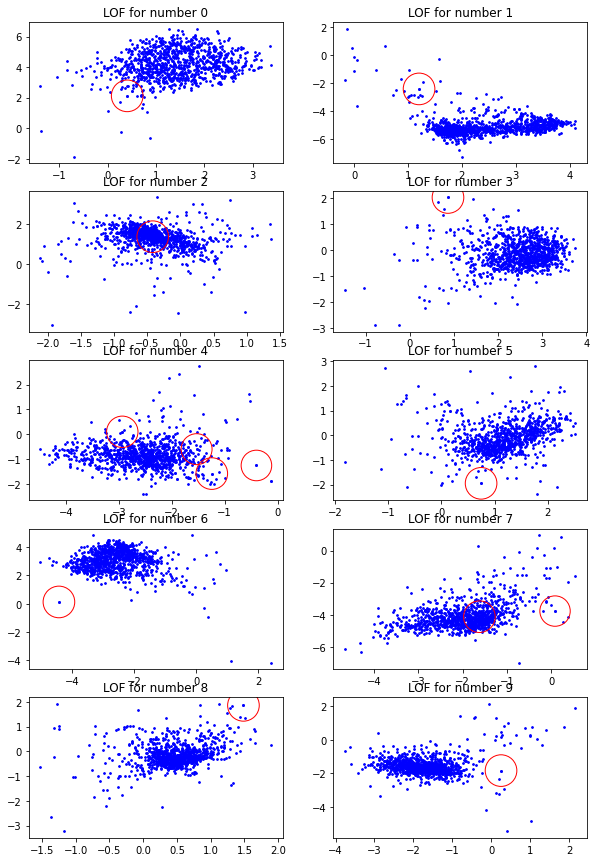

In [228]:
from sklearn.neighbors import LocalOutlierFactor

idx = []
fig, ax = plt.subplots(5,2,figsize=(10,15))
ax = ax.flatten()
for num in range(10):
    mask = cvae_z['label']==num
    mask_idx = np.arange(cvae_z['label'].shape[0])[mask]
    X = cvae_z[mask]

    clf = LocalOutlierFactor(n_neighbors=30, contamination=0.5)
    y_pred = clf.fit_predict(vae_z[mask])
    X_scores = clf.negative_outlier_factor_
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    idx.append(mask_idx[np.argmax(radius)])
    
    ax[num].title.set_text('LOF for number {}'.format(num))
    ax[num].scatter(X['x'], X['y'], color='b', s=3., label='Data points')
    # plot circles with radius proportional to the outlier scores
#     ax[num].scatter(X['x'], X['y'], s=1000 * radius, edgecolors='b',
#                 facecolors='none', label='Outlier scores')
    mask_ = radius>0.9 # np.argmax(radius)
    ax[num].scatter(X['x'][mask_], X['y'][mask_], color='b', s=3., label='Data points')
    ax[num].scatter(X['x'][mask_], X['y'][mask_], s=1000 * radius[mask_], edgecolors='r',
            facecolors='none', label='Outlier scores')


From each class we choose one anomaly point as an example. From the figue below, we can compare anomaly point in latent space and its image in original dataset.

Text(0.5, 1.0, '9')

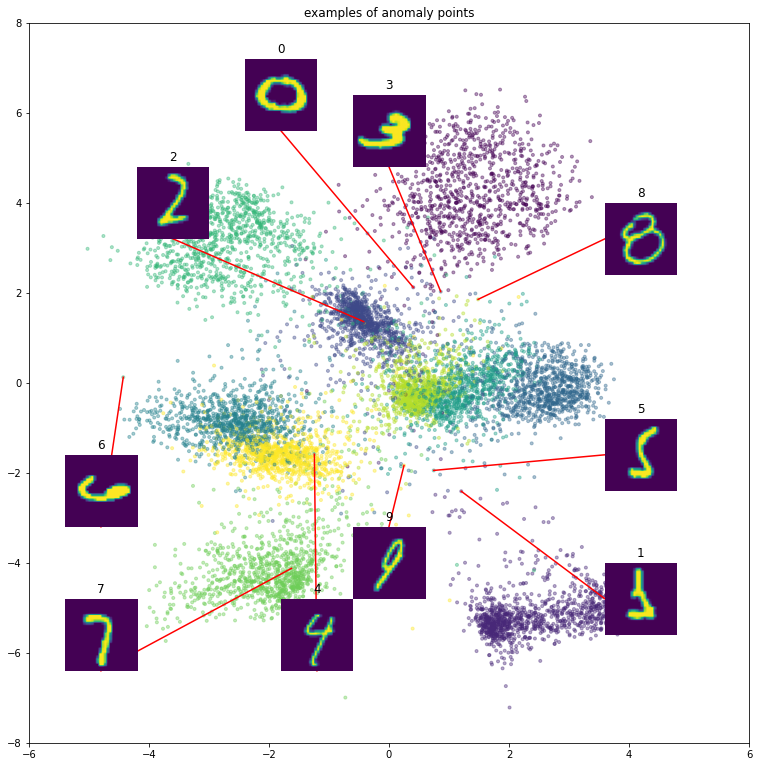

In [275]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0,0,1,1])
ax.scatter(cvae_z['x'], cvae_z['y'], c=cvae_z['label'], alpha=.4, s=3**2, cmap='viridis')
ax.set_title('examples of anomaly points')
plt.xlim([-6,6])
plt.ylim([-8,8])
plt.plot([cvae_z.iloc[idx[0]]['x'],0.35*12-6],[cvae_z.iloc[idx[0]]['y'],0.85*16-8],c='r')
plt.plot([cvae_z.iloc[idx[1]]['x'],0.8*12-6],[cvae_z.iloc[idx[1]]['y'],0.2*16-8],c='r')
plt.plot([cvae_z.iloc[idx[2]]['x'],0.2*12-6],[cvae_z.iloc[idx[2]]['y'],0.7*16-8],c='r')
plt.plot([cvae_z.iloc[idx[3]]['x'],0.5*12-6],[cvae_z.iloc[idx[3]]['y'],0.8*16-8],c='r')
plt.plot([cvae_z.iloc[idx[4]]['x'],0.4*12-6],[cvae_z.iloc[idx[4]]['y'],0.1*16-8],c='r')
plt.plot([cvae_z.iloc[idx[5]]['x'],0.8*12-6],[cvae_z.iloc[idx[5]]['y'],0.4*16-8],c='r')
plt.plot([cvae_z.iloc[idx[6]]['x'],0.1*12-6],[cvae_z.iloc[idx[6]]['y'],0.3*16-8],c='r')
plt.plot([cvae_z.iloc[idx[7]]['x'],0.1*12-6],[cvae_z.iloc[idx[7]]['y'],0.1*16-8],c='r')
plt.plot([cvae_z.iloc[idx[8]]['x'],0.8*12-6],[cvae_z.iloc[idx[8]]['y'],0.7*16-8],c='r')
plt.plot([cvae_z.iloc[idx[9]]['x'],0.5*12-6],[cvae_z.iloc[idx[9]]['y'],0.3*16-8],c='r')


left, bottom, width, height = 0.3, 0.85, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[0]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(0))

left, bottom, width, height = 0.8, 0.15, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[1]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(1))

left, bottom, width, height = 0.15, 0.7, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[2]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(2))

left, bottom, width, height = 0.45, 0.8, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[3]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(3))

left, bottom, width, height = 0.35, 0.1, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[4]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(4))

left, bottom, width, height = 0.8, 0.35, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[5]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(5))

left, bottom, width, height = 0.05, 0.3, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[6]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(6))

left, bottom, width, height = 0.05, 0.1, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[7]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(7))

left, bottom, width, height = 0.8, 0.65, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[8]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(8))

left, bottom, width, height = 0.45, 0.2, 0.1, 0.1
ax2 = fig.add_axes([left, bottom, width, height])
plt.imshow(x_test[idx[9]].reshape([28,28]))
ax2.axis('off')
ax2.set_title('{}'.format(9))


<div id="refer-anchor-1"></div>
[1]E. Norlander and A. Sopasakis, "Latent space conditioning for improved classification and anomaly detection"

<div id="refer-anchor-2"></div>
[2]https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/#fn:1

<div id="refer-anchor-3"></div>
[3]https://github.com/bojone/vae/blob/master/vae_keras_cluster.py

<div id="refer-anchor-4"></div>
[4]D. P. Kingma and M. Welling, “Auto-Encoding Variational Bayes,” in Proceedings of the 2nd International Conference on Learning Representations (ICLR), 2014.



# VAE

In [564]:
#https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/#fn:1
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
#%conda env export > requirements.yml

In [565]:
def sampling(args):
    z_mu, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim)) #default mean=0, stddev=1
    return z_mu + K.exp(.5*z_log_var) * epsilon

In [566]:
# biuld the model

original_dim, intermediate_dim, latent_dim = 784, 256, 2
batch_size = 100
epochs = 50

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var]) # sampling

x_recon = decoder(z)

vae = Model(inputs=x, outputs=x_recon)

#keras.losses.binary_crossentropy gives the mean over the last axis. we require the sum
xent_loss = K.sum(K.binary_crossentropy(x, x_recon), axis=-1) 
kl_loss = K.mean(- .5 * K.sum(1 + z_log_var - K.square(z_mu) - K.exp(z_log_var), axis=-1))
vae_loss = xent_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')#, loss=nll)

In [567]:
# train the VAE on MNIST digits
(x_train, Y_train), (x_test, Y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

# encoder.save('encoder.h5')
# decoder.save('decoder.h5')
# vae.save('vae.h5')

Epoch 1/50
600/600 [==============================] - 19s 28ms/step - loss: 217.3122 - val_loss: 171.9512
Epoch 2/50
600/600 [==============================] - 14s 23ms/step - loss: 170.8399 - val_loss: 167.7007
Epoch 3/50
600/600 [==============================] - 15s 25ms/step - loss: 166.9669 - val_loss: 164.9505
Epoch 4/50
600/600 [==============================] - 16s 27ms/step - loss: 164.1345 - val_loss: 163.3721
Epoch 5/50
600/600 [==============================] - 14s 24ms/step - loss: 162.1369 - val_loss: 161.4744
Epoch 6/50
600/600 [==============================] - 18s 30ms/step - loss: 160.9045 - val_loss: 159.9577
Epoch 7/50
600/600 [==============================] - 11s 18ms/step - loss: 159.5575 - val_loss: 158.9932
Epoch 8/50
600/600 [==============================] - 11s 18ms/step - loss: 158.5489 - val_loss: 157.9597
Epoch 9/50
600/600 [==============================] - 10s 17ms/step - loss: 157.4834 - val_loss: 157.5768
Epoch 10/50
600/600 [=========================

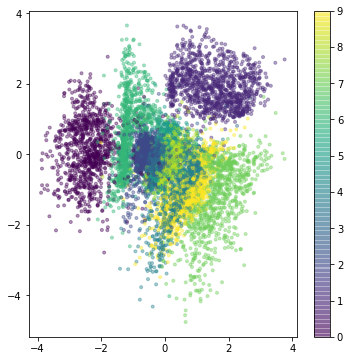

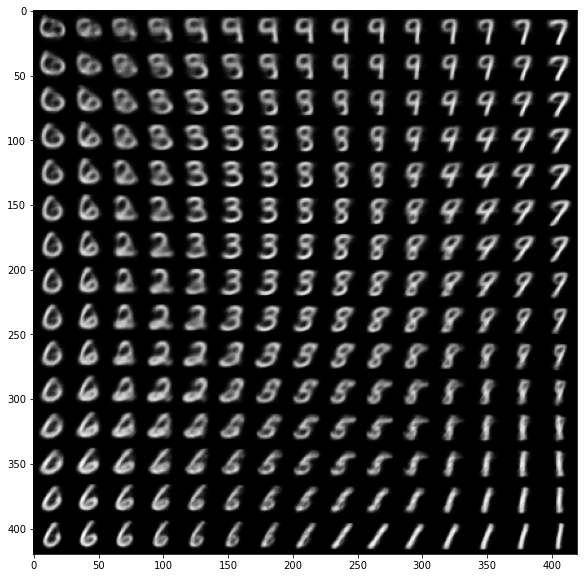

In [568]:
# encoder = tf.keras.models.load_model('encoder.h5', custom_objects={'KLDivergenceLayer':KLDivergenceLayer()})
# decoder = tf.keras.models.load_model('decoder.h5', custom_objects={'KLDivergenceLayer':KLDivergenceLayer()})
# vae = tf.keras.models.load_model('vae.h5', custom_objects={'KLDivergenceLayer':KLDivergenceLayer(), 'nll':nll})

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
# np.savetxt('vae_z.txt',np.c_[z_test,Y_test],fmt='%.3e',delimiter=",",header='x,y,label',comments='')
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

## CVAE

In [37]:
#https://github.com/bojone/vae/blob/master/vae_keras_cluster.py
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate

original_dim, intermediate_dim, latent_dim = 784, 256, 2
batch_size = 100
epochs = 50

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

label = Input(shape=(num_classes,))
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var]) # sampling

x_recon = decoder(z)

class Gaussian(Layer):
    """这是个简单的层，定义q(z|y)中的均值参数，每个类别配一个均值。
    然后输出“z - 均值”，为后面计算loss准备。
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)
    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                                    shape=(self.num_classes, latent_dim),
                                    initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_classes': self.num_classes
        })
        return config
    
gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)


# 建立模型
cvae = Model([x,label], [x_recon, z_prior_mean])

# 下面一大通都是为了定义loss
z_mu = K.expand_dims(z_mu, 1)
z_log_var = K.expand_dims(z_log_var, 1)

lamb = 0.3 # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(label, 1), kl_loss), 0)
# cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
cvae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss)# + K.sum(cat_loss)


cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
# cvae.summary()

In [38]:
(x_train, Y_train), (x_test, Y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim).astype(np.float32) / 255.
x_test = x_test.reshape(-1, original_dim).astype(np.float32) / 255.

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

cvae.fit([x_train,y_train],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=[x_test,y_test])


encoder = Model([x,label], z_mu)

# encoder.save('cvae_encoder.h5')
# decoder.save('cvae_decoder.h5')
# cvae.save('cvae.h5')

Epoch 1/50
288/600 [=============>................] - ETA: 4s - loss: 15.2584

_NotOkStatusException: InvalidArgumentError: Error while reading CompositeTensor._type_spec.

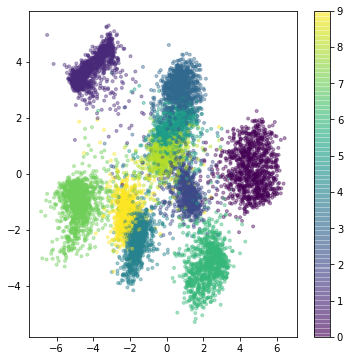

In [39]:
encoder = tf.keras.models.load_model('cvae_encoder.h5', custom_objects={'Gaussian':Gaussian(num_classes)})
decoder = tf.keras.models.load_model('cvae_decoder.h5', custom_objects={'Gaussian':Gaussian(num_classes)})
cvae = tf.keras.models.load_model('cvae.h5', custom_objects={'Gaussian':Gaussian(num_classes)})

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict([x_test,y_test], batch_size=batch_size)
# np.savetxt('cvae_z.txt',np.c_[z_test,Y_test],fmt='%.3e',delimiter=",",header='x,y,label',comments='')
z_test = z_test.squeeze()
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=Y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

### Anomaly detection

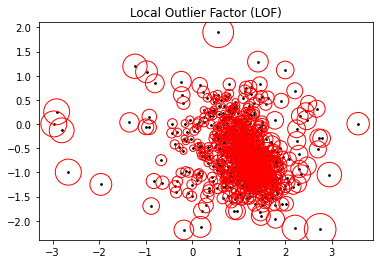

In [40]:
from sklearn.neighbors import LocalOutlierFactor

y = np.argmax(y_test, axis=-1)
mask = y==2
X = encoder.predict([x_test[mask],y_test[mask]], batch_size=batch_size)

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_


plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')



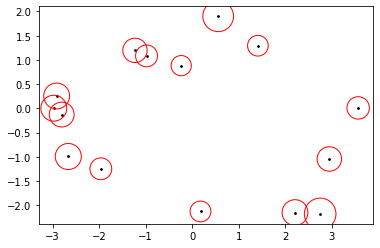

In [556]:
mask_=radius>0.4
plt.scatter(X[:, 0][mask_], X[:, 1][mask_], color='k', s=3., label='Data points')
plt.scatter(X[:, 0][mask_], X[:, 1][mask_], s=1000 * radius[mask_], edgecolors='r',
            facecolors='none', label='Outlier scores')

In [ ]:
for layer in vae.layers:
    weights = layer.get_weights()  # list of numpy array
    print(layer.name, weights)

# Other coding style for keras

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import layers

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np

tf.keras.backend.clear_session()  # For easy reset of notebook state.


class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj(inputs)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_proj(inputs)
    return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32,
               name='autoencoder',
               **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

  def call(self, inputs):
    # self._set_inputs(inputs)
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss)
    return reconstructed


In [6]:

original_dim = 784
vae = VariationalAutoEncoder(original_dim, 256, 2)  #, input_shape=(784,)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.BinaryCrossentropy()##tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, original_dim).astype(np.float32) / 255.
x_test = x_test.reshape(-1, original_dim).astype(np.float32) / 255.

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Iterate over epochs.
for epoch in range(50):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      # !!! uncomment the following two lines to use workaround and skip !!!
      # if step == 0 and epoch == 0:
      #   vae._set_inputs(x_batch_train)
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      #x_batch_train = tf.cast(x_batch_train, tf.float32)
#       loss = nll(x_batch_train, reconstructed) #if use mse_loss_fn as loss function, need multiply 100.
      loss = 100*mse_loss_fn(x_batch_train, reconstructed)
      loss += sum(vae.losses)  # Add KLD regularization loss

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)
    if step % 100 == 0:
      print('step %s: mean loss = %s' % (step, loss_metric.result()))
vae.save('vae')


# # or train like this
# vae = VariationalAutoEncoder(original_dim, 256, 2)  #, input_shape=(784,)
# vae.compile(optimizer='rmsprop', loss=nll)

# vae.fit(x_train,
#         x_train,
#         shuffle=True,
#         epochs=50,
#         batch_size=100,
#         validation_data=(x_test, x_test))

Start of epoch 0
step 0: mean loss = tf.Tensor(69.520096, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(38.369698, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(32.546906, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(30.225502, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(28.941887, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(28.009687, shape=(), dtype=float32)
step 600: mean loss = tf.Tensor(27.37552, shape=(), dtype=float32)
step 700: mean loss = tf.Tensor(26.867733, shape=(), dtype=float32)
step 800: mean loss = tf.Tensor(26.464987, shape=(), dtype=float32)
step 900: mean loss = tf.Tensor(26.099138, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(25.989872, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(25.721655, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(25.491507, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(25.311552, shape=(), dtype=float32)
step 400: mean loss

INFO:tensorflow:Assets written to: vae/assets


INFO:tensorflow:Assets written to: vae/assets


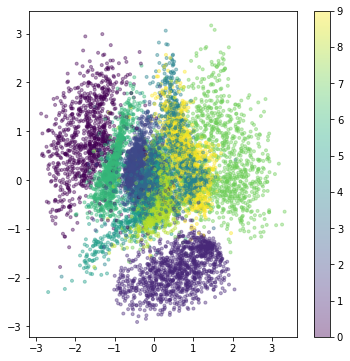

In [7]:
import matplotlib.pyplot as plt

z_test, z_log_var, z = vae.encoder(x_test)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()